# 1st Import and Get the data

### Import the Packages

In [41]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests 
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import folium
from scipy.cluster.hierarchy import linkage,fcluster,dendrogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

### Get the data

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df=pd.read_html(url)[0]
df=df.loc[df['Borough'] != 'Not assigned',:]
url2='http://cocl.us/Geospatial_data'
geo_info=pd.read_csv(url2)
df_withgeo=pd.merge(df,geo_info,left_on='Postal Code',right_on='Postal Code',how='outer')

### Extract the data of Toronto

In [3]:
df_Toronto=df_withgeo.loc[df_withgeo['Borough'].str.find('Toronto')>=0]

### Define:
* The Foursquare Credentials and Version
* To get the top 100 venus with 500 meter of the neighborhood

In [7]:
CLIENT_ID = '0QHM0LDENEU5RMPVXRQTCV4OABG0N5F3XBODATNQIN4SGAM2'
CLIENT_SECRET = 'SAA3XJOEAGHN2J04ZRM5CZL1TAHDVZHG1PI0M2ELQCPX5E1W'
VERSION = '20180605'
radius = 500
LIMIT = 100

###  Get the venus around the neighborhood in Toronto

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'] 
    return(nearby_venues)

In [10]:
Toronto_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

### Now we get the venues infotmation in the Toronto, let's analysis it

In [13]:
Toronto_venues.to_csv('Toronto_venues.csv')

In [39]:
print('There are {} neighborhoods.'.format(len(Toronto_venues['Neighborhood'].unique())))

There are 39 neighborhoods.


In [19]:
mean_venus=Toronto_venues.groupby(by='Neighborhood')['Venue'].count().mean()
mean_venus_category=Toronto_venues.groupby(by='Neighborhood')['Venue Category'].nunique().mean()

In [22]:
print('On average, each neighborhood has {} venuse'.format(np.round(mean_venus,0)))

On average, each neighborhood has 41.0 venuse


### Top 10 Neighborhood with most venues

In [33]:
Toronto_top10=Toronto_venues.groupby(by='Neighborhood')['Venue'].count().sort_values(ascending=False).head(10)

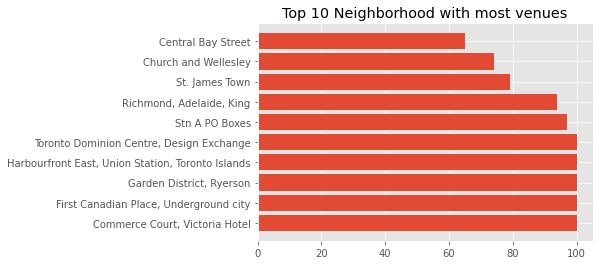

In [38]:
plt.style.use('ggplot')
plt.barh(Toronto_top10.index,Toronto_top10.values)
plt.title("Top 10 Neighborhood with most venues")
plt.show()

### Here is Mary's scorecard:
|Venue Category|Scores|
|-|-|
|Shopping Mall|15|
|Park|13|
|Coffee|10|
|Yoga|7|
|Gym|7|
|Italian Restaurant|5|
|American Restaurant|5|
|Japanese Restaurant|5|
|Movie|5|
|Theater|5|
|Museum|5|


### Now combine the data and scorecard together to rank the neighborhood to help Mary make decision.

In [42]:
Toronto_venues=pd.read_csv('Toronto_venues.csv',index_col=0)
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


### Let's do the scorecard:

In [84]:
Score1_list=[]
Score2_list=[]
Score3_list=[]
Score4_list=[]
Score5_list=[]
Score6_list=[]
Score7_list=[]
Score8_list=[]
Score9_list=[]
Score10_list=[]
Score11_list=[]
for Neighborhood in Toronto_venues['Neighborhood'].unique().tolist():
    sub=Toronto_venues.loc[Toronto_venues['Neighborhood']==Neighborhood,'Venue Category']
    if (sub.str.find('Shopping Mall')>=0).sum()>0:
        Score1=15
    else:
        Score1=0
    Score1_list.append(Score1)
    if (sub.str.find('Park')>=0).sum()>0:
        Score2=13
    else:
        Score2=0
    Score2_list.append(Score2)
    if (sub.str.find('Coffee')>=0).sum()>0:
        Score3=10
    else:
        Score3=0
    Score3_list.append(Score3)
    if (sub.str.find('Yoga')>=0).sum()>0:
        Score4=7
    else:
        Score4=0
    Score4_list.append(Score4)
    if (sub.str.find('Gym')>=0).sum()>0:
        Score5=7
    else:
        Score5=0
    Score5_list.append(Score5)
    if (sub.str.find('Italian Restaurant')>=0).sum()>0:
        Score6=5
    else:
        Score6=0
    Score6_list.append(Score6)
    if (sub.str.find('American Restaurant')>=0).sum()>0:
        Score7=5
    else:
        Score7=0
    Score7_list.append(Score7)
    if (sub.str.find('Japanese Restaurant')>=0).sum()>0:
        Score8=5
    else:
        Score8=0
    Score8_list.append(Score8)
    if (sub.str.find('Movie')>=0).sum()>0:
        Score9=5
    else:
        Score9=0
    Score9_list.append(Score9)
    if (sub.str.find('Theater')>=0).sum()>0:
        Score10=5
    else:
        Score10=0
    Score10_list.append(Score10)
    if (sub.str.find('Museum')>=0).sum()>0:
        Score11=5
    else:
        Score11=0
    Score11_list.append(Score11)

In [89]:
Toronto_scores=pd.DataFrame({'Neighborhood':Toronto_venues['Neighborhood'].unique().tolist(),
                            'Score1':Score1_list,'Score2':Score2_list,'Score3':Score3_list,'Score4':Score4_list,'Score5':Score5_list,
                             'Score6':Score6_list,'Score7':Score7_list,'Score8':Score8_list,'Score9':Score9_list,
                             'Score10':Score10_list,'Score11':Score11_list})

In [92]:
Toronto_scores['Total Score']=Toronto_scores[['Score1','Score2','Score3','Score4',
                                              'Score5','Score6','Score7','Score8','Score9','Score10','Score11']].sum(axis=1)

In [93]:
Toronto_final=pd.merge(df_Toronto,Toronto_scores[['Neighborhood','Total Score']]
                       ,left_on='Neighborhood',right_on='Neighborhood')

### Now Cluster the Neighborhoods based on the total score

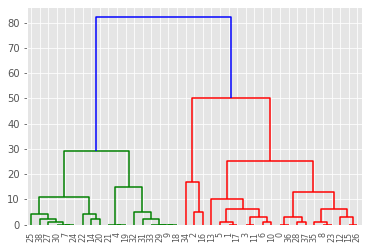

In [105]:
Z=linkage(Toronto_final[['Total Score']],method='complete')
dendrogram(Z)
plt.xticks(rotation=90)
plt.show()

### choose k=3 based on the chart!

In [106]:
Toronto_final['labels']=fcluster(Z,3,criterion='maxclust')

In [109]:
Toronto_final=Toronto_final.sort_values('Total Score',ascending=False)

In [116]:
Toronto_final.groupby('labels')['Total Score'].mean()

labels
1    16.777778
2    72.333333
3    43.944444
Name: Total Score, dtype: float64

### Label 2 Clusters has the highest score while label one has the lowest
***

In [111]:
Toronto_final.loc[Toronto_final['labels']==2]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Total Score,labels
34,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,82,2
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,70,2
16,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,65,2


# <font color='red'>*Stn A PO Boxes, Garden District, Ryerson, Commerce Court, Victoria Hotel*</font> are Mary's first choice
***

### Finally, let's visualize the neiborhood in the map

In [112]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [117]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

rainbow = ['black','red','blue']
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_final['Latitude'], Toronto_final['Longitude'], Toronto_final['Neighborhood'], Toronto_final['labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters